<font color = "green">**Detection of Pulmonary diseases with U-NET and Segmentation **</font>



<font color="green">Note:</font> We used the dataset "Montgomery" under full dataset on the given kaggle [link](https://www.kaggle.com/raddar/tuberculosis-chest-xrays-montgomery).

We couldnt find anything regarding use of EarlyStop in unet_learner, so we did something heuristic.


We continue dealing with pulmonary diseases. However, instead of making sure to prevent the spreading, we focus on early recognition. In particular, in this task we check chest x-rays for signs of pulmonary diseases.

In [ ]:
pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 53.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread as imread
from skimage.transform import resize as resize
from glob import glob
from tqdm import tqdm
import cv2
import gc

from albumentations import Compose, ShiftScaleRotate, Rotate, RandomScale
import os
import matplotlib.pyplot as plt
import seaborn



In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip drive/MyDrive/Exercise4/Montgomery.zip

In [ ]:
for dirname, _, filenames in os.walk('Montgomery'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
image_paths = glob(os.path.join('Montgomery', 'MontgomerySet', 'CXR_png', '*.png'))

In [ ]:
images_with_masks_paths = [(image_path,
                      os.path.join('/'.join(image_path.split('/')[:-2]), "ClinicalReadings", os.path.basename(image_path)[:-4]+".txt"),
                      os.path.join('/'.join(image_path.split('/')[:-2]), 'ManualMask', 'leftMask', os.path.basename(image_path)), 
                      os.path.join('/'.join(image_path.split('/')[:-2]), 'ManualMask', 'rightMask', os.path.basename(image_path))) for image_path in image_paths]

In [ ]:
images_with_masks_paths[0][2]

'Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0316_1.png'

In [ ]:
cv2.imread(images_with_masks_paths[40][0]).shape

(4020, 4892, 3)

In [ ]:
dataset = pd.DataFrame()

In [ ]:
for data_info in images_with_masks_paths:
  textfile = open(data_info[1],"r+")
  text = textfile.readlines()
  sex = text[0][-3:-2]
  age = int(text[1][-5:-2])
  status = text[2][:-1]
  image = data_info[0]
  left_lung = data_info[2]
  right_lung = data_info[3]
  row_data = {"sex": sex, "age":age,"status":status, "image":image,"left_lung":left_lung,"right_lung":right_lung}
  dataset = dataset.append(row_data,ignore_index=True)

In [ ]:
dataset["sex"].values

array(['M', 'M', 'F', 'F', ..., 'M', 'F', 'M', 'M'], dtype=object)

## **(a)** 

 First, download the CXR dataset. Display and discuss the dataset.

**Data Visulisation**

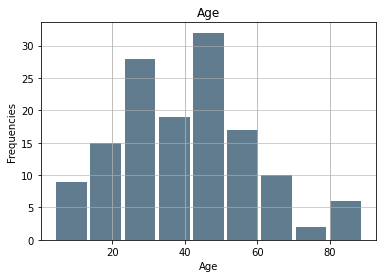

In [ ]:
dataset['age'].plot.hist(grid=True, bins=9, rwidth=0.9,
                   color='#607c8e')
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Frequencies')
plt.grid(axis='y', alpha=0.75)

<font color="purple">Discussion:</font>
The data set mostly belongs to people in over the age of 40.

Text(0, 0.5, 'Frequencies')

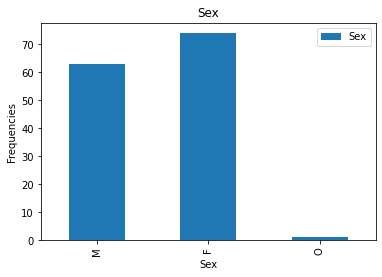

In [ ]:
from collections import Counter
letter_counts = Counter(dataset["sex"])
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.legend(["Sex"])
plt.title('Sex')
plt.xlabel('Sex')
plt.ylabel('Frequencies')

**the number of Female is more than that of male.**

In [ ]:
set(dataset['status'])

{'12x9mm nodule LUL, consistent with large granuloma or some other type of a solitary pulmonary nodule',
 'CXR similar to prior views 1M and 2M ago with some slight improvement; on HRZ(E)x2 months, AFB smears neg now, will switch to HR only (same pt as MCUCXR_0166_1, MCUCXR_0162_1)',
 'LUL inactive scars and some volume loss. h/o treatment 5 years ago.',
 'LUL infiltrate, ? small areas of cavitation, IMP: active TB',
 'NO REPORT (same pt as MCUCXR_0162_1)',
 'RUL apical fibrotic disease with some calcifications; extensive irregular infiltrates in left lung with a large area of cavitation/ findings consistent with old inactive disease in RL and new active TB in LL. On the lordotic view, in the rt apex a large thin walled cavity is visible, making active disease in the area likely as well.',
 'RUL cavitary infiltrate; positive smear',
 'RUL fibrocavitary disease with volume loss and tracheal deviation to right; COPD scoliosis;',
 'RUL infiltrate consistent with TB',
 'Rt apical scarring.

**We defined these diseases above as anormal lung**

In [ ]:
dataset["new_status"] = ["normal" if status == "normal" else "anormal" for status in dataset["status"]]

In [ ]:
set(dataset['new_status'].values)

{'anormal', 'normal'}

Text(0, 0.5, 'Frequencies')

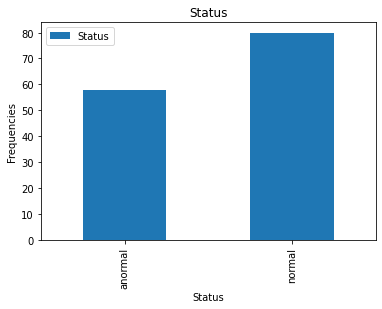

In [ ]:
from collections import Counter
letter_counts = Counter(dataset["new_status"])
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.legend(["Status"])
plt.title('Status')
plt.xlabel('Status')
plt.ylabel('Frequencies')

**The number of  Normal lungs is more than anormal lungs.**

In [ ]:
dataset['image'].count()

138

In [ ]:
label = "Montgomery/MontgomerySet/mask/mask"
label2 = "Montgomery/MontgomerySet/mask"

In [ ]:
os.mkdir(label)
os.mkdir(label2)

In [ ]:
OUT_DIM = (512, 512)

In [ ]:
def image_from_path(path):
    img = resize(imread(path), OUT_DIM, mode='constant')
    return img

def mask_from_paths(path1, path2):
    img = resize(cv2.bitwise_or(imread(path1), imread(path2)), OUT_DIM, mode='constant')
    cv2.imwrite(label+"/"+os.path.basename(path1), img)
    cv2.imwrite(label2+"/"+os.path.basename(path1), img)
    plt.imshow(img, cmap='gray')
    return img

In [ ]:
images_with_masks_paths[0]

('Montgomery/MontgomerySet/CXR_png/MCUCXR_0316_1.png',
 'Montgomery/MontgomerySet/ClinicalReadings/MCUCXR_0316_1.txt',
 'Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0316_1.png',
 'Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0316_1.png')

100%|██████████| 138/138 [05:00<00:00,  2.18s/it]


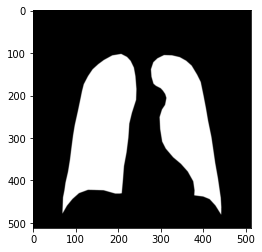

In [ ]:
images = []
masks = []

for mri,_, left_lung, right_lung in tqdm(images_with_masks_paths, position=0, leave=True):
  images.append(image_from_path(mri))
  masks.append(mask_from_paths(left_lung, right_lung))



In [ ]:
def random_plot(images, masks, number):
    indices = np.random.choice(len(images), number)
    fig, axis = plt.subplots(nrows=number, ncols=3, figsize=(20, 20))

    for i, index in enumerate(indices):
        img = images[index]
        mask = masks[index]
        axis[i][0].imshow(img, cmap='gray')
        axis[i][1].imshow(mask, cmap='gray')
        axis[i][2].imshow(cv2.addWeighted(img, 1.0, mask, 0.7, 1), cmap='gray')

    plt.tight_layout()

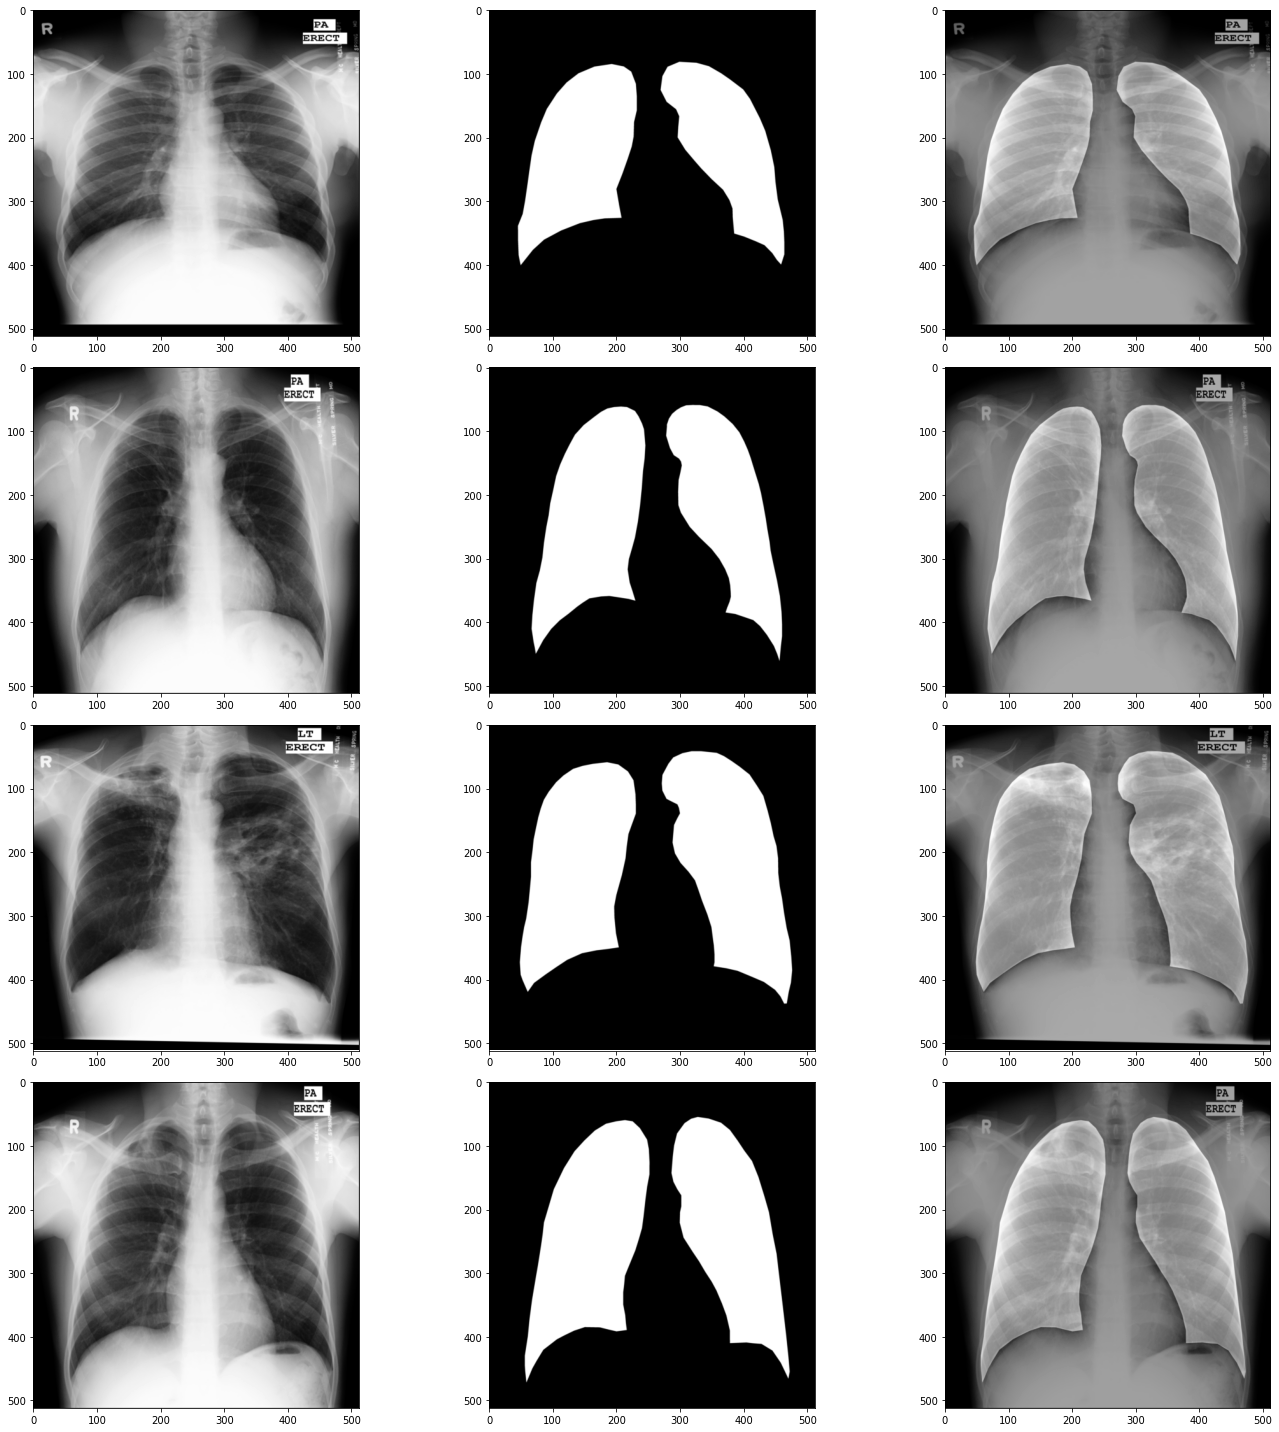

In [ ]:
random_plot(images, masks, 4)

**<font color="purple">Discussion:</font>**
The first column shows the CXR.

The second column shows the masked lungs, and the last lungs weighted CXR imaged with masked lungs. The shapes of lungs are not same for images.

## **(b)**
Using the UNet1 as basis, your task is to segment the lungs in the given x-rays. To that end, use the methods taught throughout the course.  performance of your model is measured using the dice metric and pixel accuracy. Please display theperformance of your model.

In [ ]:
#src_size = np.array(masks[1].shape)
src_size = array([512, 512])

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [ ]:
path = "Montgomery/MontgomerySet/CXR_png"

In [ ]:
#Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
import fastai
#fastai.data_block.ItemLists.transform = transform

In [ ]:
path

'Montgomery/MontgomerySet/CXR_png'

In [ ]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path)
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace("CXR_png", "mask/mask"), classes=[0, 1])
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))


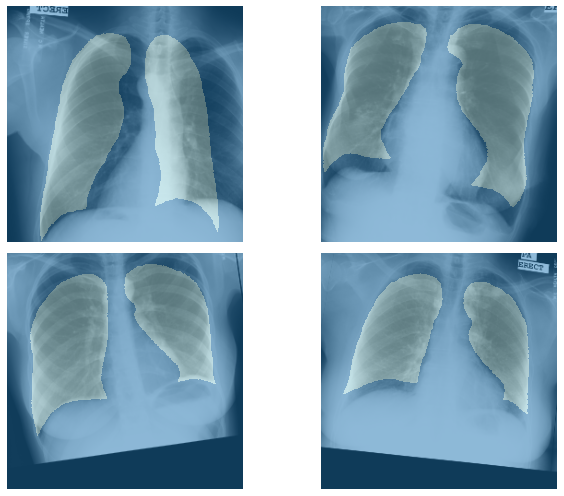

In [ ]:
# Display some images with masks
data.show_batch(2, figsize=(10,7))


As you can see the CXR images'size and rotation are different in each image, we might need to do data augmentation. The right lung in the first image on the right column might not be recognized, we might do augmentation according to first training results.

**Validation Data Set**

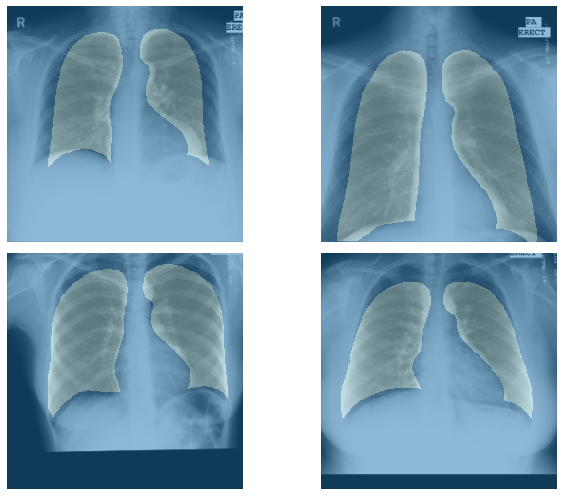

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### **DICE** and **Pixel Accuracy**

In [ ]:
def pixel_acc(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    return acc


In [ ]:
from fastai.vision import *

In [ ]:
# Create U-Net with a pretrained resnet34 as encoder
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=[dice, pixel_acc], wd = wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


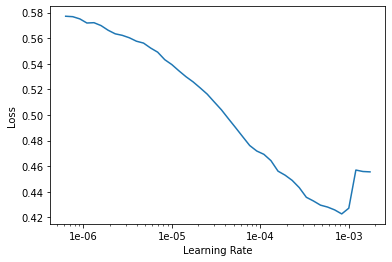

In [ ]:
lr_find(learn)
learn.recorder.plot()

According to the result of learning rate finder, we chose learning rate as 1e-03 .

In [ ]:
lr=1e-03

In [ ]:
learn.fit_one_cycle(6, slice(lr), pct_start=0.9)

The results above is quite good.

In [ ]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

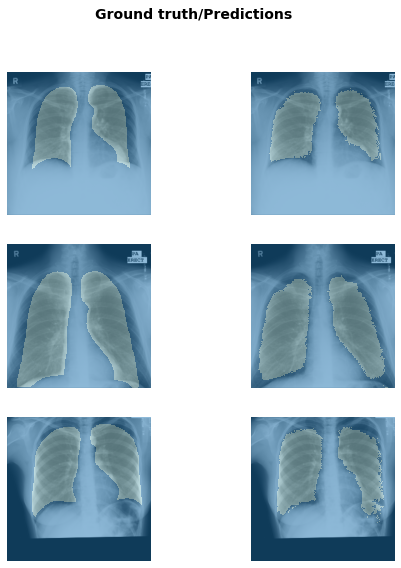

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

As you can see from the prediction above, the model should be trained more.The lungs in the images of the first and second rows could not be predicted well.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(12, slice(lr/40, lr/4), pct_start=0.8)

In [ ]:
learn.save('stage-2')

In [ ]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()


In [ ]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)



In [ ]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)


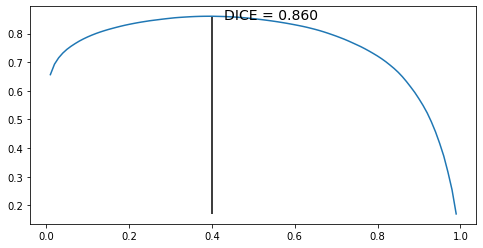

In [ ]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

Validation pixel accuracy:

In [ ]:
preds, ys = learn.get_preds()
pixel_acc(preds, ys)

tensor(0.8236)

As you can see from the figure above, DICE is 0.860 and the model predicted the lungs' segmentation properly(more than 0.5). However, the model can be trained with different techniques.
The pixel acc(8236) is near to DICE on the training.

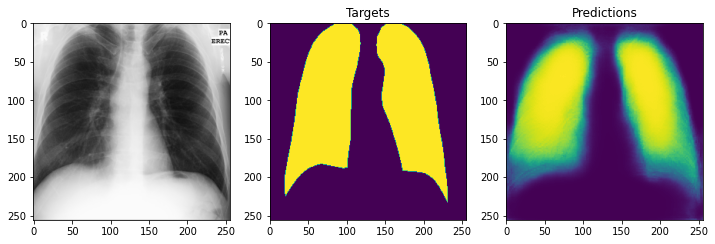

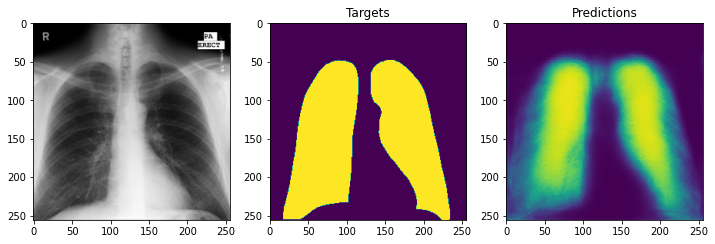

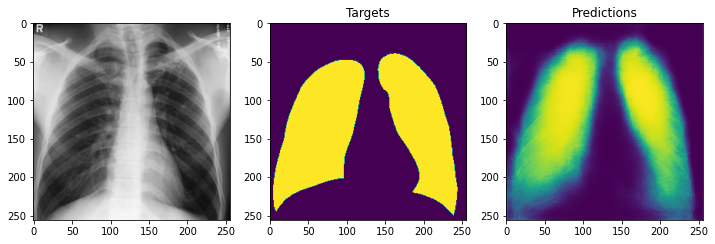

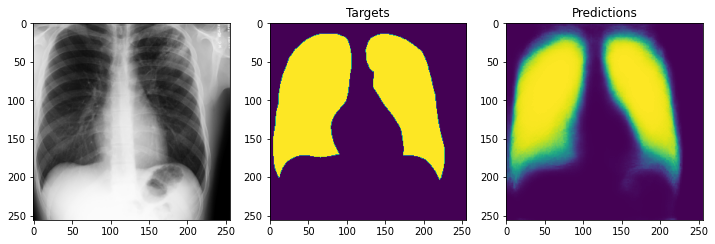

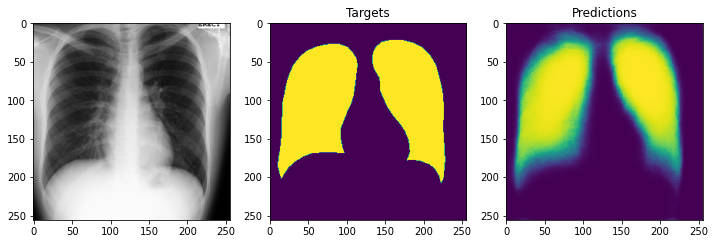

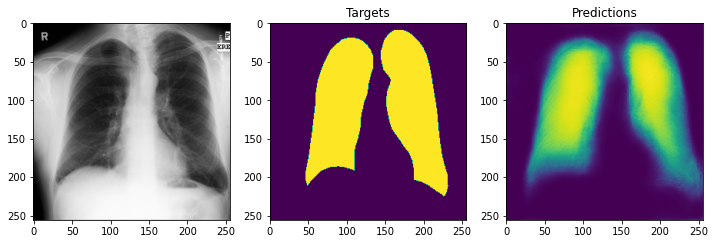

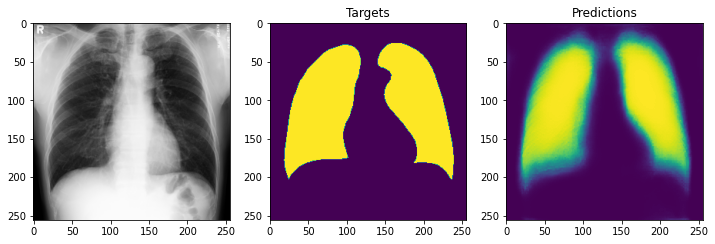

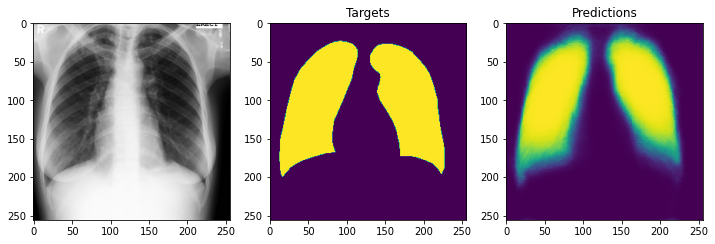

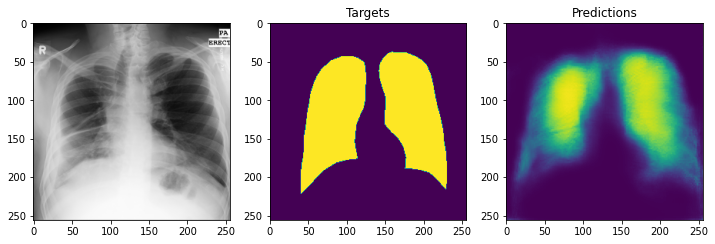

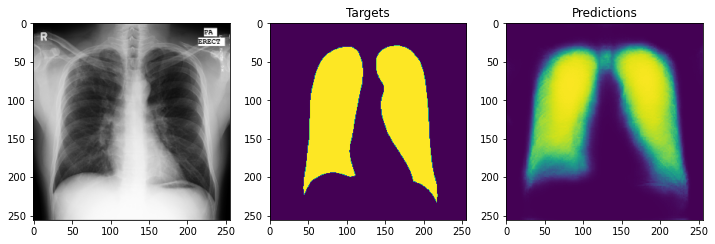

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## **(c)**

Try creative augmentations in order to improve yours results.

We define the transformation below.

In [ ]:
tfms = get_transforms(max_rotate=15, max_zoom=0.8,  max_warp=0.2,
                      p_affine=0.75, p_lighting=1.)


In [ ]:
# Create databunch
data_aug = (SegmentationItemList.from_folder(path=path)
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace("CXR_png", "mask"), classes=[0, 1])
        .transform(tfms, size=size, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))


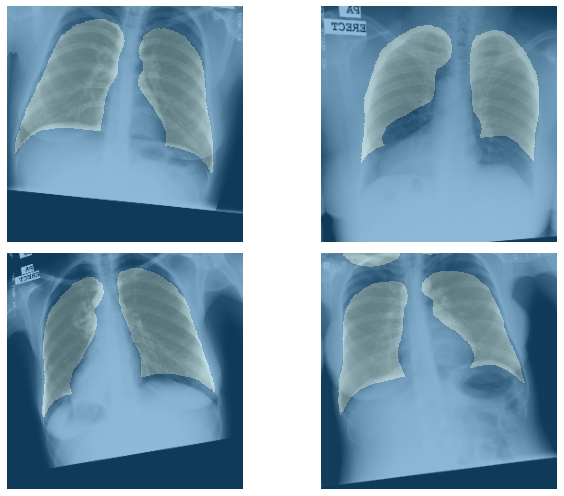

In [ ]:
# Display some images with masks
data_aug.show_batch(2, figsize=(10,7))

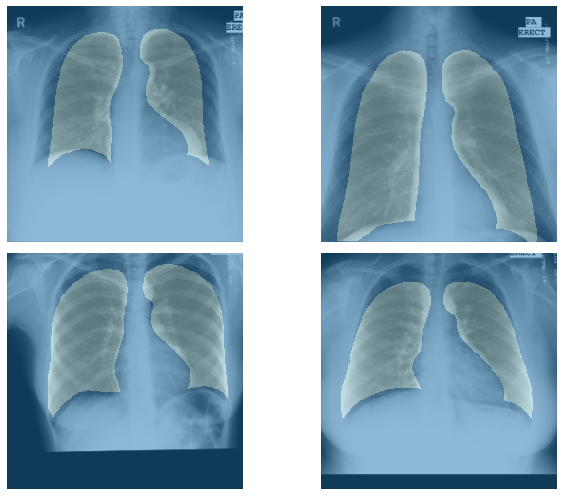

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### **DICE** and  **Pixel Accuracy**

In [ ]:
# Create U-Net with a pretrained resnet34 as encoder
learn_aug = unet_learner(data_aug, models.resnet34, metrics=[dice, pixel_acc], wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


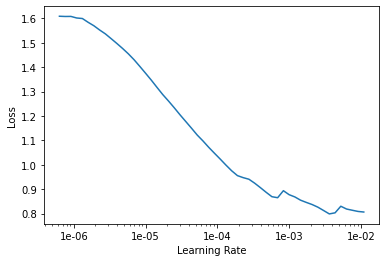

In [ ]:
lr_find(learn_aug)
learn_aug.recorder.plot()

In [ ]:
lr = 1e-04
learn_aug.fit_one_cycle(6, slice(lr), pct_start=0.9)

In [ ]:
# Unfreeze the encoder (resnet34)
learn_aug.unfreeze()

In [ ]:
learn_aug.save('stage-1')

In [ ]:
#learn_aug.load('stage-1')

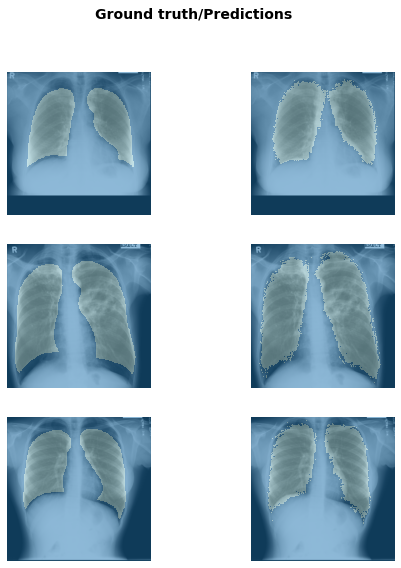

In [ ]:
learn_aug.show_results(rows=3, figsize=(8,9))

When we compare these results with the first step of previous model(without augmentation), the predictions were  improved. Let's train model more.

The model's losses was improved after data augmentation.

In [ ]:
learn_aug.unfreeze()

In [ ]:
learn_aug.fit_one_cycle(4, slice(lr/40, lr/4), pct_start=0.8)

In [ ]:
# Predictions for the validation set
preds, ys = learn_aug.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [ ]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)


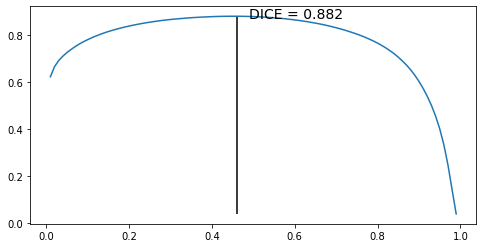

In [ ]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

The result of the model trained with augmented data has the highest DICE value than previous model.

**Results:**

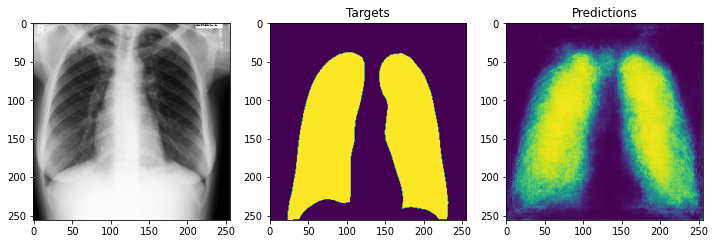

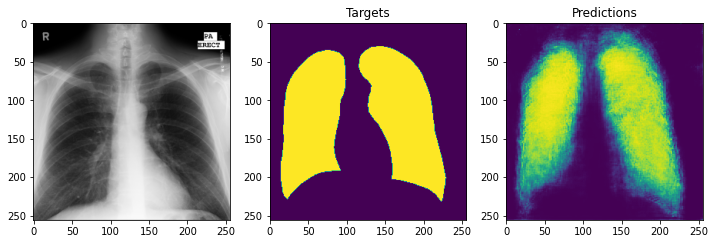

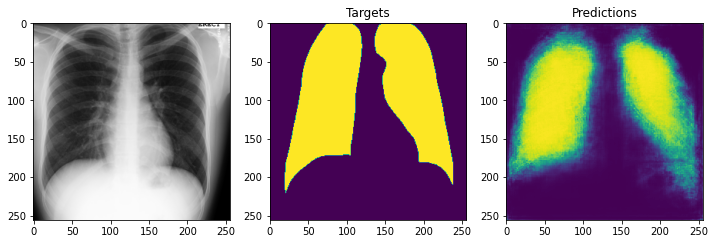

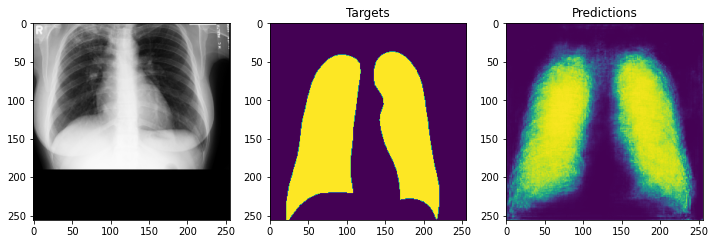

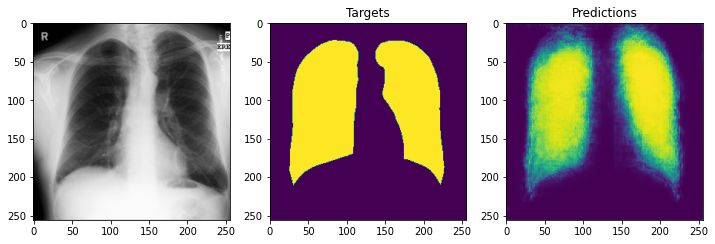

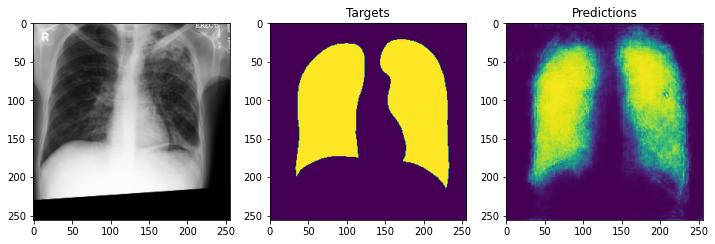

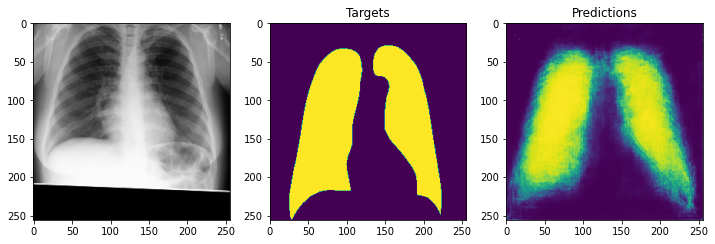

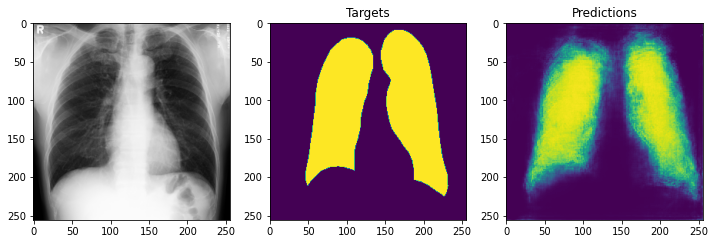

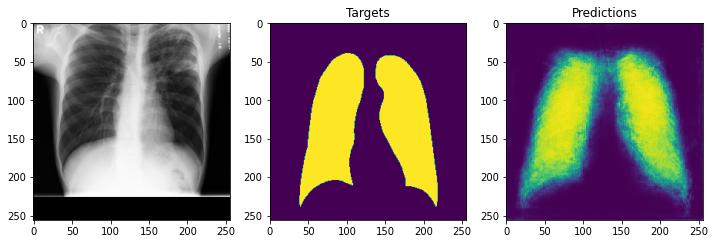

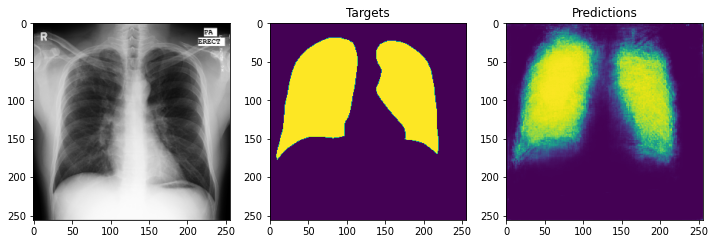

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

**<font color="purple"> Conclusion:</font>**

As you can see from the result,
after the data augmentation techniques, the metrics'results were improved.

